## Context

Implement the approximation model from 

- http://spaceex.imag.fr/sites/default/files/cav2011_appendix.pdf

- http://spaceex.imag.fr/sites/default/files/paper_55.pdf

In [1]:
using Revise, ReachabilityAnalysis

# include("sdof.jl")
using ReachabilityAnalysis
const RA = ReachabilityAnalysis

# Struct that holds a problem describing an harmonic oscillator with frequency ω:
# x''(t) + ω^2 x(t) = 0
#
# If x(0) = A, x'(0) = 0 => x(t) = A cos ωt
struct SDOF{T, ST}
    ivp::T
    X0::ST
    ω::Float64    
    Ampl::Float64
    T::Float64
end

amplitude(p::SDOF) = p.Ampl
frequency(p::SDOF) = p.ω
period(p::SDOF) = p.T
MathematicalSystems.initial_state(p::SDOF) = p.X0
MathematicalSystems.InitialValueProblem(p::SDOF) = p.ivp
MathematicalSystems.state_matrix(p::SDOF) = state_matrix(p.ivp)

function analytic_solution(p::SDOF)
    @assert p.X0 isa Singleton && iszero(element(p.X0)[2]) "the analytic solution is not implemented for this case"
    A = p.Ampl
    ω = p.ω
    return t -> A * cos(ω * t)
end

function InitialValueProblem_quad(p::SDOF)
    M = hcat(1.0)
    ω = p.ω
    K = hcat(ω^2)
    C = zeros(1, 1)
    R = zeros(1)
    S = SecondOrderAffineContinuousSystem(M, C, K, R)
    @assert p.X0 isa Singleton
    x0 = element(p.X0)
    U0 = [x0[1]]
    U0dot = [x0[2]]
    return IVP(S, (U0, U0dot))
end

function sdof(; T=0.5,     # period
                Ampl=1.0,  # amplitude
                X0 = Singleton([Ampl, 0.0])) # initial condition
    # frequency
    ω = 2π / T

    # cast as a first-order system:
    # x' = v
    # v' = -ω^2 * x
    A = [ 0.0     1.0;
         -ω^2     0.0]

    prob = @ivp(X' = AX, X(0) ∈ X0)
    return SDOF(prob, X0, ω, Ampl, T) 
end



┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


sdof (generic function with 1 method)

## Running example

In [42]:
using Plots

p = sdof()
prob = IVP(p)
asol = analytic_solution(p)
T = period(p)
A = state_matrix(p)

tmax = 2.0
dom = 0:0.01:tmax

α = 0.1

a = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=α*T, approx_model=StepIntersect(setops=:concrete)));
b = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=α*T, approx_model=CorrectionHull(exp=:base)));
c = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=α*T, approx_model=Forward(setops=:concrete)));

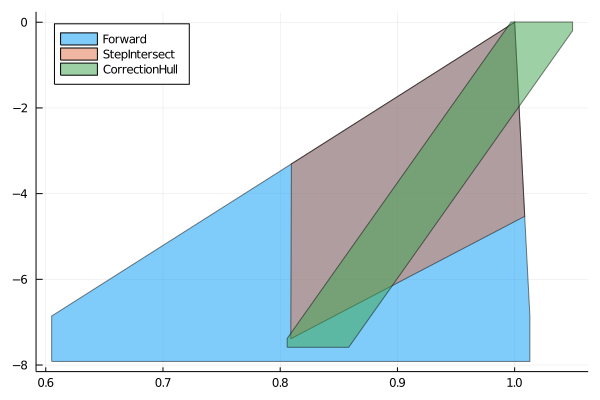

In [40]:
plot(c[1], vars=(1, 2), lab="Forward", legend=:topleft)
plot!(a[1], vars=(1, 2), lab="StepIntersect")
plot!(b[1], vars=(1, 2), lab="CorrectionHull")

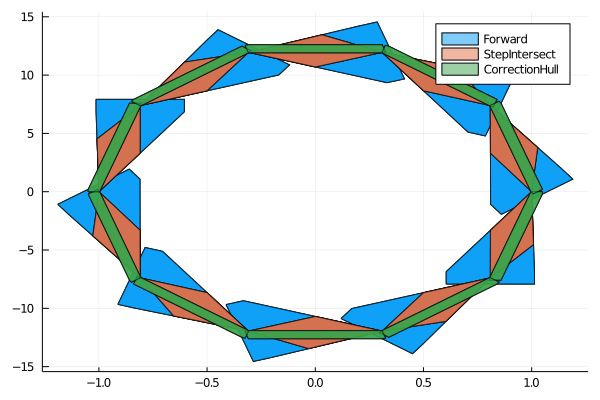

In [38]:
plot(c, vars=(1, 2), lab="Forward")
plot!(a, vars=(1, 2), lab="StepIntersect")
plot!(b, vars=(1, 2), lab="CorrectionHull")

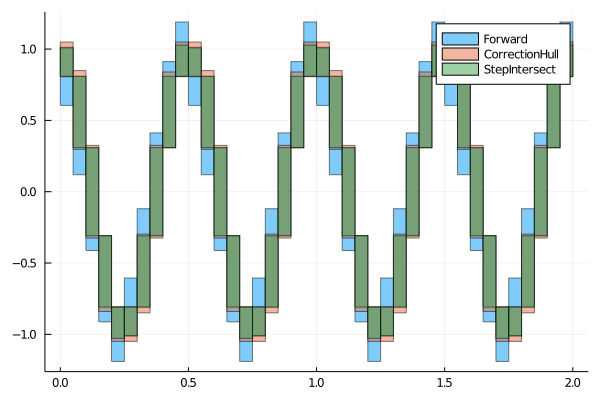

In [27]:
plot(c, vars=(0, 1), lab="Forward")
plot!(b, vars=(0, 1), lab="CorrectionHull")
plot!(a, vars=(0, 1), lab="StepIntersect")

In [32]:
mid(tspan(c[1]))

0.025

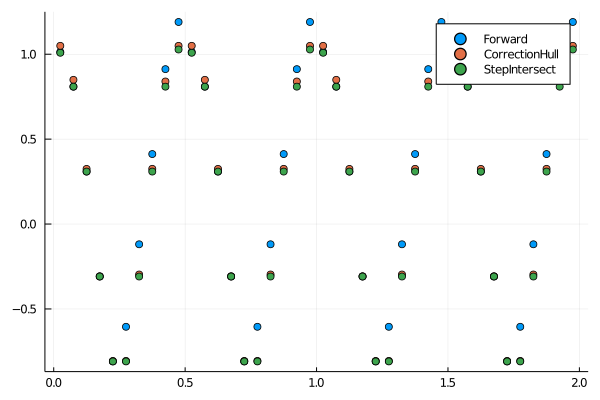

In [35]:
NORTH = [1.0, 0.0]
SOUTH = [-1.0, 0.0]

fig = plot(xlab="time", ylab="x(t)")
plot([mid(tspan(X)) for X in c], [ρ(NORTH, X) for X in c], vars=(0, 1), lab="Forward", seriestype=:scatter)
plot!([mid(tspan(X)) for X in b], [ρ(NORTH, X) for X in b], vars=(0, 1), lab="CorrectionHull", seriestype=:scatter)
plot!([mid(tspan(X)) for X in a], [ρ(NORTH, X) for X in a], vars=(0, 1), lab="StepIntersect", seriestype=:scatter)

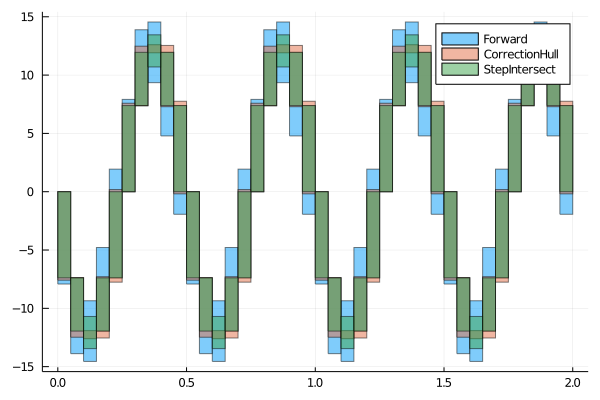

In [28]:
plot(c, vars=(0, 2), lab="Forward")
plot!(b, vars=(0, 2), lab="CorrectionHull")
plot!(a, vars=(0, 2), lab="StepIntersect")

## Test

In [50]:
include("/home/mforets/.julia/dev/ReachabilityAnalysis/test/models/harmonic_oscillator.jl")
prob, _ = harmonic_oscillator()

tmax = 2.0

    a = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=0.1, approx_model=Forward(setops=:concrete)));
    b = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=0.1, approx_model=StepIntersect(setops=:concrete)));
    c = solve(prob, tspan=(0.0, tmax), alg=VREP(δ=0.1, approx_model=CorrectionHull(exp=:base)));

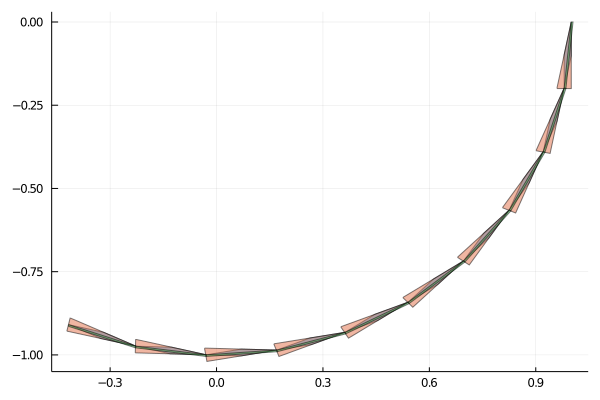

In [55]:
plot(a, vars=(1, 2))

plot!(c, vars=(1, 2))
plot!(b, vars=(1, 2))

## Homogeneous case

## Inhomogeneous case